In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [2]:
X, y, features, categ, sch_nan = ds.load_mimic_dataset()

In [3]:
sorted(y["time"])[::-1]

[4404.0,
 4336.0,
 4274.0,
 4234.0,
 4136.0,
 4088.0,
 4075.0,
 3980.0,
 3966.0,
 3941.0,
 3892.0,
 3839.0,
 3833.0,
 3821.0,
 3816.0,
 3762.0,
 3751.0,
 3708.0,
 3635.0,
 3628.0,
 3607.0,
 3603.0,
 3602.0,
 3594.0,
 3556.0,
 3554.0,
 3553.0,
 3515.0,
 3512.0,
 3486.0,
 3480.0,
 3478.0,
 3473.0,
 3463.0,
 3462.0,
 3448.0,
 3447.0,
 3439.0,
 3429.0,
 3426.0,
 3424.0,
 3390.0,
 3388.0,
 3379.0,
 3376.0,
 3372.0,
 3370.0,
 3368.0,
 3351.0,
 3349.0,
 3328.0,
 3325.0,
 3316.0,
 3315.0,
 3304.0,
 3299.0,
 3294.0,
 3289.0,
 3275.0,
 3264.0,
 3257.0,
 3256.0,
 3245.0,
 3240.0,
 3238.0,
 3236.0,
 3222.0,
 3198.0,
 3184.0,
 3173.0,
 3172.0,
 3164.0,
 3154.0,
 3150.0,
 3146.0,
 3140.0,
 3134.0,
 3120.0,
 3112.0,
 3111.0,
 3098.0,
 3097.0,
 3088.0,
 3085.0,
 3075.0,
 3072.0,
 3070.0,
 3065.0,
 3061.0,
 3050.0,
 3049.0,
 3037.0,
 3032.0,
 3032.0,
 3026.0,
 3023.0,
 3023.0,
 3011.0,
 3010.0,
 3005.0,
 3002.0,
 2993.0,
 2992.0,
 2987.0,
 2982.0,
 2979.0,
 2976.0,
 2976.0,
 2970.0,
 2968.0,
 2967.0,
 

In [4]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

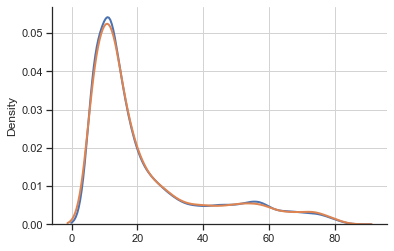

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
# X, y, features, categ, sch_nan = ds.load_smarto_dataset()
# X, y, features, categ, sch_nan = ds.load_support2_dataset()
# X, y, features, categ, sch_nan = ds.load_metabric_dataset()
X, y, features, categ, sch_nan = ds.load_mimic_dataset()
# X, y, features, categ, sch_nan = ds.load_rott2_dataset()

y["time"] = np.log1p(y["time"]) * 10

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

<Axes: ylabel='Density'>

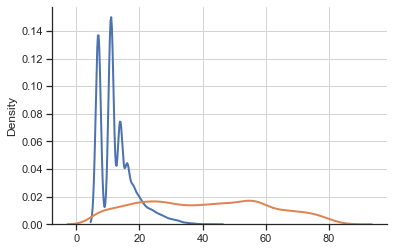

In [6]:
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 0)[0]]["time"], label="train")
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 1)[0]]["time"], label="train")

(0.0, 83.9049553837028)

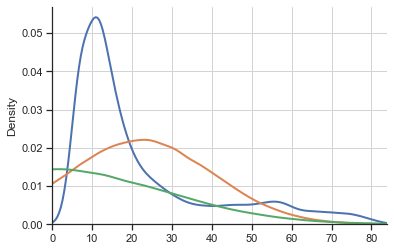

In [7]:
import scipy.stats as stats
from scipy.optimize import root, fsolve

def equations(l_var, mu_e, sigma_e):
    mu, sigma = l_var
    alpha = -mu/sigma
    phi_a = 1/np.sqrt(2*np.pi) * np.exp(-1/2*(alpha**2))
    Z = 1 - stats.norm.cdf(alpha)
    eq1 = mu + phi_a * sigma / Z - mu_e + (mu < 0)*np.exp(-mu*1e5)
    eq2 = ((sigma / sigma_e)**2) * (1 + alpha*phi_a/Z - (phi_a/Z)**2) - 1 + (sigma < 0)*np.exp(-sigma*1e5)
    return [eq1, eq2]


class TruncNorm:
    _ctor_param = {"name": "TruncNorm"}
    @staticmethod
    def fit(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        solution = fsolve(equations, [mu_e, sigma_e], args=(mu_e, sigma_e))
        return solution
#         solution = root(lambda x: equations(x, mu_e, sigma_e), [mu_e, sigma_e])
#         print("Solution:", solution.x)
#         return solution.x

    @staticmethod
    def rvs(mu, sigma, size, random_state=42):
        return stats.norm.rvs(mu, sigma, size=size, random_state=random_state)
    
    @staticmethod
    def valid(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        params = TruncNorm.fit(y)
        a = TruncNorm.rvs(*params, size=100000, random_state=42)
        a = a[a > 0]
        print(mu_e, np.mean(a))
        print(sigma_e, np.std(a))
        

sns.kdeplot(y_tr["time"])
for st in [stats.norm, TruncNorm, 
#            stats.lognorm, stats.gamma, stats.laplace, stats.laplace_asymmetric, 
#            stats.rayleigh, stats.weibull_min, stats.genlogistic
          ]:
    params = st.fit(y_tr["time"])
    sns.kdeplot(st.rvs(*params, size=100000, random_state=42))
plt.xlim((0, y_tr["time"].max()))

In [8]:
st.rvs(*params, size=100000, random_state=42)

array([13.75924972, -3.78992221, 17.93179356, ..., 11.34017113,
       -5.80268346,  3.34957859])

In [9]:
# TruncNorm.valid(y_["time"])
TruncNorm.valid(y["time"])

22.063519451800566 22.07979836381189
18.061063773811657 16.692595762149008


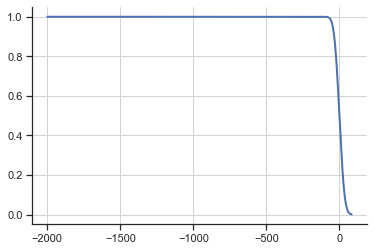

In [10]:
params = TruncNorm.fit(y["time"])

a = TruncNorm.rvs(*params, size=100000, random_state=42)
a = a[a > 0]
    
x = np.linspace(-2000, y["time"].max(), 1000)
plt.plot(x, stats.norm.sf(x, *params))

### Informative censuring comparison

In [11]:
from survivors.external.nonparametric import KaplanMeier

# X, y, features, categ, sch_nan = ds.load_smarto_dataset()
# X, y, features, categ, sch_nan = ds.load_metabric_dataset()
X, y, features, categ, sch_nan = ds.load_seer_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

KaplanMeierZeroAfter IBS:0.12186, AUPRC:0.80816
KaplanMeierZeroAfterTh IBS:0.11550, AUPRC:0.84665
KaplanMeierZeroAfterEmp IBS:0.11423, AUPRC:0.84819


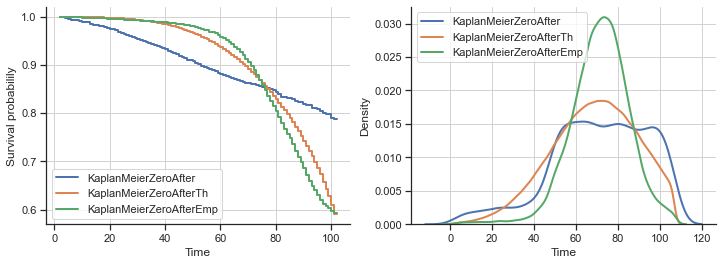

In [12]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterTh(KaplanMeier):
    def __init__(self, d_type, size=1000000, *args, **kwargs):
        self.d_type = d_type
        self.size = size
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None, censuring=True):
#         q1, q2 = np.quantile(durations, [0.05, 0.95])
        params = self.d_type.fit(durations)
        self.durs = self.d_type.rvs(*params, size=self.size, random_state=self.size)
        if censuring:
            self.events = np.random.choice(right_censor, size=self.size, replace=True)
        else:
            self.events = np.ones_like(self.durs)
        self.durs = np.hstack([durations.copy(), self.durs])
        self.events = np.hstack([right_censor.copy(), self.events])

        ind = (self.durs >= durations.min()) & (self.durs <= durations.max())
#         ind = (self.durs >= q1) & (self.durs <= q2)
        self.events = self.events[ind]
        self.durs = self.durs[ind]
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterEmp(KaplanMeierZeroAfter):
    """
    Nonparametric model with virtual events generated by bootstrap meaning
    """
    def __init__(self, n=2, size=20000, *args, **kwargs):
        self.n = n
        self.size = size
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.choice(durations, size=(self.n, self.size), replace=True).mean(axis=0)
        self.events = np.random.choice(right_censor, size=self.size, replace=True)
        
        self.durs = np.hstack([durations.copy(), self.durs])
        self.events = np.hstack([right_censor.copy(), self.events])
        super().fit(self.durs, self.events)

np.random.seed(42)
km = KaplanMeierZeroAfter()
km1 = KaplanMeierZeroAfterTh(stats.norm)
# km2 = KaplanMeierZeroAfterTh(TruncNorm)
km2 = KaplanMeierZeroAfterEmp(4)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for km_ in [km, km1, km2]:
    km_.fit(y["time"], y["cens"])
    sf_ = km_.survival_function_at_times(bins_HO)
    ibs_sf = metr.ibs_remain(y, y, np.repeat(sf_[np.newaxis, :], y.shape[0], axis=0), bins_HO)
    auprc_sf = metr.auprc(y, y, np.repeat(sf_[np.newaxis, :], y.shape[0], axis=0), bins_HO)
    print(f"{type(km_).__name__} IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
    
    axes[0].step(bins_HO, sf_, label=type(km_).__name__)
    sns.kdeplot(km_.durs, ax=axes[1], label=type(km_).__name__)
    
axes[0].legend()
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time");

In [13]:
from tqdm import tqdm
from joblib import Parallel, delayed

def get_km_ibs(y, bins_HO, s, rs=42, km_model=None):
    np.random.seed(rs)
    km = km_model(s)   # KaplanMeierZeroAfterTh(TruncNorm, size=s)
    km.fit(y["time"], y["cens"])
    sf = km.survival_function_at_times(bins_HO)
    ibs_sf_ = metr.ibs_remain(y, y, np.repeat(sf[np.newaxis, :], y.shape[0], axis=0), bins_HO)
    ibs_sf_vec = metr.ibs_remain(y, y, np.repeat(sf[np.newaxis, :], y.shape[0], axis=0), bins_HO, axis=1)
    auprc_sf_ = metr.auprc(y, y, np.repeat(sf[np.newaxis, :], y.shape[0], axis=0), bins_HO)
    return ibs_sf_, auprc_sf_, sf, ibs_sf_vec

def get_metric_km_sizes(y, bins, km_model):
    sizes = np.hstack([0, 10**np.arange(1, 7)])
    repeats = 1000
    d = {"sizes": [], "ibs": [], "auprc": [], "sf": [], "ibs_vec": []}
    for s in sizes:
        print(s)
        with Parallel(n_jobs=20, verbose=1) as parallel:
            ml = parallel(delayed(get_km_ibs)(y, bins, s, rs=rs, km_model=km_model) for rs in range(repeats))
        d["ibs"] += [m[0] for m in ml]
        d["auprc"] += [m[1] for m in ml]
        d["sf"] += [m[2] for m in ml]
        d["ibs_vec"] += [m[3] for m in ml]
        d["sizes"] += [s for _ in range(repeats)]
    return pd.DataFrame(d)

df_trunc = get_metric_km_sizes(y, bins_HO, lambda s: KaplanMeierZeroAfterTh(TruncNorm, size=s))
df_emp_2 = get_metric_km_sizes(y, bins_HO, lambda s: KaplanMeierZeroAfterEmp(n=2, size=s))
df_emp_4 = get_metric_km_sizes(y, bins_HO, lambda s: KaplanMeierZeroAfterEmp(n=4, size=s))

#     for rs in tqdm(range(repeats), ncols=20, ascii=True, desc='Total'):
#         ibs_sf_ = get_km_ibs(y, bins_HO, s, rs=rs)
#         d["ibs"].append(ibs_sf_)
#         d["sizes"].append(s)

0


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    7.6s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   12.0s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:   14.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


10


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    9.5s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:   11.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


100


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    9.4s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:   11.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1000


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    3.6s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:   12.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


10000


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    9.4s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:   11.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


100000


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:   11.0s
[Parallel(n_jobs=20)]: Done 1000 out of 1000 | elapsed:   13.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1000000


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   22.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   54.3s


KeyboardInterrupt: 

In [14]:
def visualize_df(df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    sns.boxplot(df, y="ibs", x="sizes", ax=axes[0])
    sns.boxplot(df, y="auprc", x="sizes", ax=axes[1])
    
    fig, axes = plt.subplots(figsize=(10, 6))
    for s, r in df.groupby("sizes")["sf"].agg(np.mean).items():
        axes.plot(r, label=s)
    plt.legend()
    
#     fig, axes = plt.subplots(figsize=(15, 6))
#     df_res = pd.DataFrame(d)
#     df_res["sizes"] = df_res["sizes"].astype("category")
#     sns.kdeplot(df_res, x="ibs", hue="sizes", ax=axes, 
#                 hue_order=sizes,
#                 common_grid=True, fill=True)

visualize_df(df_trunc)

NameError: name 'df_trunc' is not defined

In [15]:
visualize_df(df_emp_2)

NameError: name 'df_emp_2' is not defined

In [16]:
visualize_df(df_emp_4)

NameError: name 'df_emp_4' is not defined

In [17]:
params = TruncNorm.fit(y["time"])
durs = TruncNorm.rvs(*params, size=30000, random_state=42)
events = np.random.choice(y["cens"], size=30000, replace=True)

ind = (durs >= y["time"].min()) & (durs <= y["time"].max())
events = events[ind]
durs = durs[ind]

<Axes: ylabel='Density'>

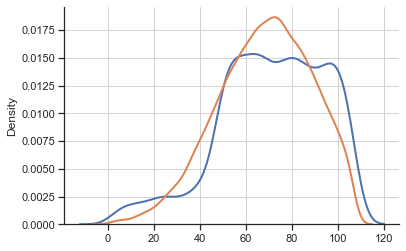

In [18]:
sns.kdeplot(y["time"])
sns.kdeplot(durs)

In [19]:
np.histogram(durs, bins=5000)[0].mean(), durs.mean()

(5.6274, 68.34202896845845)

<Axes: ylabel='Density'>

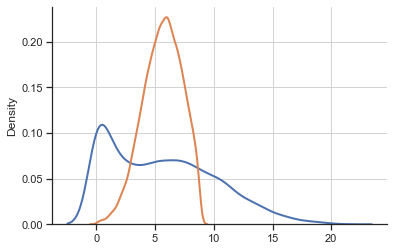

In [20]:
s1 = np.histogram(durs, bins=5000)[0]
s2 = durs # np.random.choice(durs, size=5000) # durs

sns.kdeplot(s1)
# kernel = stats.gaussian_kde(durs)
# sns.kdeplot(kernel(np.linspace(0, 100, 1000)).T)
sns.kdeplot(s2 / s2.mean() * s1.mean())

In [21]:
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

# stats.kstest(s1, s2 / s2.mean() * s1.mean())
stats.wasserstein_distance(s1, s2 / s2.mean() * s1.mean())
# kl_div(s1, s2 / s2.mean() * s1.mean()).sum()
# jensenshannon(s1, s2 / s2.mean() * s1.mean())

2.439330876072791

In [22]:
stats.kstest(np.histogram(durs, bins=10000)[0], np.histogram(durs, bins=5000)[0])

KstestResult(statistic=0.3227, pvalue=1.3023615674439168e-307, statistic_location=5, statistic_sign=1)

In [23]:
ibs_sf_ = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf1_ = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf2_ = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)

plt.plot(ibs_sf_)
plt.plot(ibs_sf1_)
plt.plot(ibs_sf2_)
plt.show()

auprc_sf_ = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf1_ = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf2_ = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
plt.plot(auprc_sf_)
plt.plot(auprc_sf1_)
plt.plot(auprc_sf2_)
plt.show()

NameError: name 'y_' is not defined

In [24]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

# X_scaled = StandardScaler().fit_transform(X.fillna(X.median()))
# X_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42).fit_transform(X_scaled)
# sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
#                 hue=y["cens"])

In [25]:
# cmap = sns.cubehelix_palette(as_cmap=True)
# f, ax = plt.subplots(figsize=(20, 10))
# ind = np.where(y["cens"] == 1)[0]
# points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
#                 c=y[ind]["time"], cmap=cmap)
# f.colorbar(points)

# f, ax = plt.subplots(figsize=(20, 10))
# ind = np.where(y["cens"] == 0)[0]
# points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
#                 c=y[ind]["time"], cmap=cmap)
# f.colorbar(points)

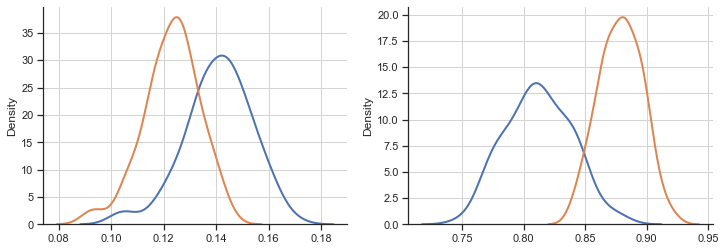

0.1408&0.1229&2.008e-21
0.8122&0.8788&8.867e-49


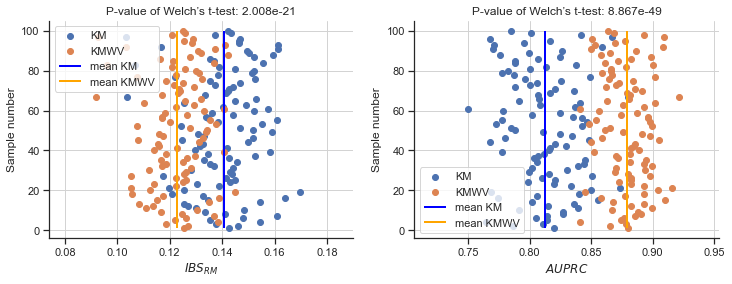

In [26]:
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(1)

for i, _ in enumerate(x):
    x_sub = df.sample(n=int(X.shape[0]*0.05), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
#     km = KaplanMeierZeroAfterTh(TruncNorm)
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfterTh(stats.norm)
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(ibs_1, ax=axes[0])
sns.kdeplot(ibs_2, ax=axes[0])
x_ibs_min, x_ibs_max = axes[0].get_xlim()

sns.kdeplot(auprc_1, ax=axes[1])
sns.kdeplot(auprc_2, ax=axes[1])
x_auprc_min, x_auprc_max = axes[1].get_xlim()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(ibs_1, x, label="KM")
axes[0].scatter(ibs_2, x, label="KMWV")
axes[0].vlines([np.mean(ibs_1)], ymin=min(x), ymax=max(x), color="blue", label="mean KM")
axes[0].vlines([np.mean(ibs_2)], ymin=min(x), ymax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
axes[0].legend()
axes[0].set_ylabel("Sample number")
axes[0].set_xlabel(r"$IBS_{RM}$")
axes[0].set_xlim(x_ibs_min, x_ibs_max)
print(f"{np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")

axes[1].scatter(auprc_1, x, label="KM")
axes[1].scatter(auprc_2, x, label="KMWV")
axes[1].vlines([np.mean(auprc_1)], ymin=min(x), ymax=max(x), color="blue", label="mean KM")
axes[1].vlines([np.mean(auprc_2)], ymin=min(x), ymax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
print(f"{np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
axes[1].legend()
axes[1].set_xlim(x_auprc_min, x_auprc_max)

axes[1].set_ylabel("Sample number")
axes[1].set_xlabel(r"$AUPRC$");

In [28]:
from survivors.tree import CRAID
from lifelines import CoxPHFitter

def split_by_tree(X, y, categ=[]):
    p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 5, 
         'leaf_model': 'base', 'min_samples_leaf': 0.02, 'signif': 0.05, 'woe': True}

    tree = CRAID(**p)
    tree.fit(X, y)
    return tree.predict(X, target="numb")
    

def print_metric_by_model(df, subsample=0.3, prefix="", censuring=True, categ=[], cox=False):
    ibs_1 = []
    ibs_2 = []
    auprc_1 = []
    auprc_2 = []
    np.random.seed(1)
    
    d = {}
    for i in range(int(1/subsample*5)):
        x_sub = df.sample(n=int(df.shape[0]*subsample), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
        time = x_sub["time"].to_numpy()
        cens = x_sub["cens"].to_numpy()

        bins_ = cnt.get_bins(time=time)
        y_src = cnt.get_y(cens=cens, time=time)
        
        strats = [y_src]
        
#         if tree:
#             X_ = x_sub[[c for c in x_sub.columns if not(c in ["time", "cens"])]]
#             nodes = split_by_tree(X_, y_src, categ=categ)
#             strats = [y_src[np.where(nodes == n)[0]] for n in set(nodes)]
#         print(len(strats))
        for y_v in strats:
            for th in ["", 2, 4, 6, stats.norm, TruncNorm, stats.lognorm, stats.gamma, stats.laplace, 
                       stats.laplace_asymmetric, stats.rayleigh, stats.weibull_min, stats.genlogistic]:
                if th == "":
                    suff = "km"
                    km = KaplanMeierZeroAfter()
                elif isinstance(th, int):
                    suff = f"Emp({th})"
                    km = KaplanMeierZeroAfterEmp(th, censuring=censuring)
                else:
                    suff = th._ctor_param["name"]
                    km = KaplanMeierZeroAfterTh(th, censuring=censuring)
                km.fit(y_v["time"], y_v["cens"])
                sf = km.survival_function_at_times(bins_)
                
                if cox:
                    try:
                        cph = CoxPHFitter(penalizer=10)
                        cph.fit(x_sub.fillna(0), 'time', 'cens', strata=categ)
                        sf_ = (sf[:, np.newaxis] ** cph.predict_partial_hazard(x_sub.fillna(0)).values).T
                    except Exception as err:
                        print(type(err))
                        print(err)
                        sf_ = np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0)
                else:
                    sf_ = np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0)
                
                ibs_ = metr.ibs_remain(y_v, y_v, sf_, bins_)
                auprc_ = metr.auprc(y_v, y_v, sf_, bins_)
                if suff+"IBS" in d:
                    d[suff+"IBS"].append(ibs_)
                else:
                    d[suff+"IBS"] = [ibs_]
                if suff+"AUPRC" in d:
                    d[suff+"AUPRC"].append(auprc_)
                else:
                    d[suff+"AUPRC"] = [auprc_]
    
    d_ = {k: np.mean(v) for k, v in d.items()}
    d_["dataset"] = prefix
    d_["subsample"] = subsample
    return d_

#     print(f"{prefix + '|'}IBS:({subsample}): {np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
#     print(f"{prefix + '|'}AUPRC({subsample}): {np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")

In [29]:
from survivors.datasets import DATASETS_LOAD

l = []
for ds_name in ["metabric", "mimic", "rott2", "seer", "smarto", "support2", "GBSG"]:
    X, y, features, categ, sch_nan = DATASETS_LOAD[ds_name]()
    bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    
    for subsample in [1, 0.7, 0.5, 0.3, 0.1, 0.05]:
#         d = print_metric_by_model(df, subsample=subsample, prefix=ds_name, censuring=False)
        d = print_metric_by_model(df, subsample=subsample, prefix=ds_name, censuring=True, categ=categ, cox=True)
        l.append(d)
        print(d)
    
df_res = pd.DataFrame(l).T
df_res.to_csv("./CoxFullTheoryResultsTable.csv")
# df_res.to_csv("./ClearDoubleTheoryResultsTable.csv")

{'kmIBS': 0.14374840163365574, 'kmAUPRC': 0.5514997781565103, 'Emp(2)IBS': 0.13889860885100586, 'Emp(2)AUPRC': 0.6179062914520757, 'Emp(4)IBS': 0.14386583417905727, 'Emp(4)AUPRC': 0.6289618854967023, 'Emp(6)IBS': 0.14765276364842608, 'Emp(6)AUPRC': 0.6327521790726325, 'normIBS': 0.14270382871310322, 'normAUPRC': 0.6119970870988116, 'TruncNormIBS': 0.13936354801063391, 'TruncNormAUPRC': 0.5936306501405019, 'lognormIBS': 0.138891229960753, 'lognormAUPRC': 0.5999596100992842, 'gammaIBS': 0.13827061012118833, 'gammaAUPRC': 0.5934767426553492, 'laplaceIBS': 0.14049901061296077, 'laplaceAUPRC': 0.6113426155981477, 'laplace_asymmetricIBS': 0.1376159349816096, 'laplace_asymmetricAUPRC': 0.571034707885512, 'rayleighIBS': 0.13967336121084378, 'rayleighAUPRC': 0.602439621881538, 'weibull_minIBS': 0.13857044371952826, 'weibull_minAUPRC': 0.5954807045367447, 'genlogisticIBS': 0.1387393269374005, 'genlogisticAUPRC': 0.5992820163366541, 'dataset': 'metabric', 'subsample': 1}
{'kmIBS': 0.1474728489345

MemoryError: Unable to allocate 7.63 MiB for an array with shape (1000000,) and data type float64

In [67]:
df_res = pd.read_csv("./CoxDoubleTheoryResultsTable.csv", index_col=0)
df_res = df_res.T
df_res[df_res.columns[:-2]] = df_res[df_res.columns[:-2]].astype(float)
df_res["subsample"] = df_res["subsample"].astype(float)
df_res = df_res.T

GBSG


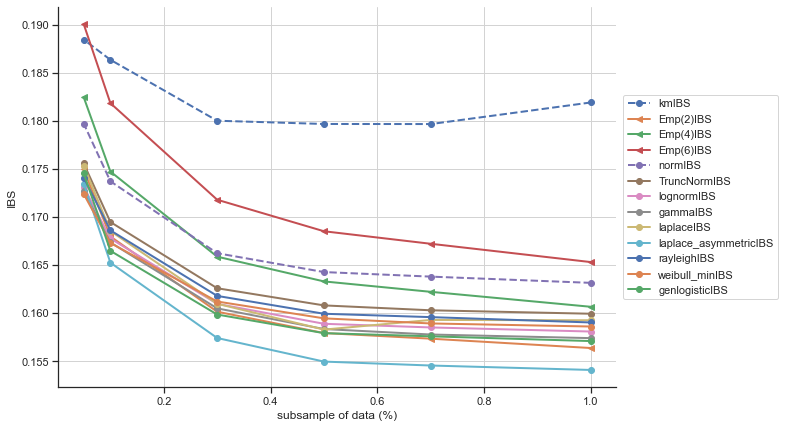

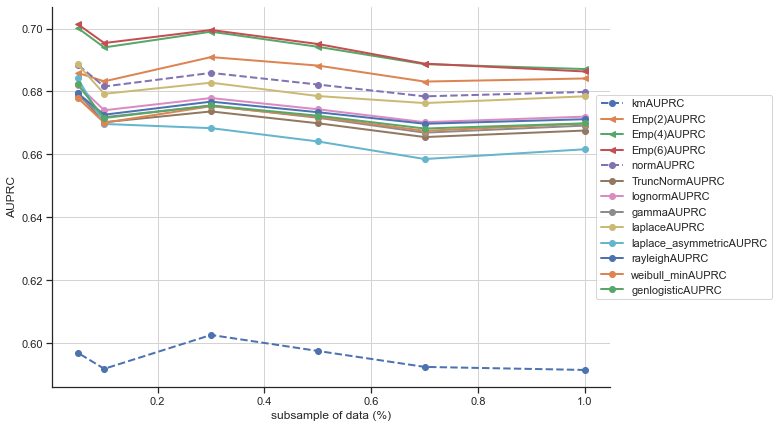

PBC


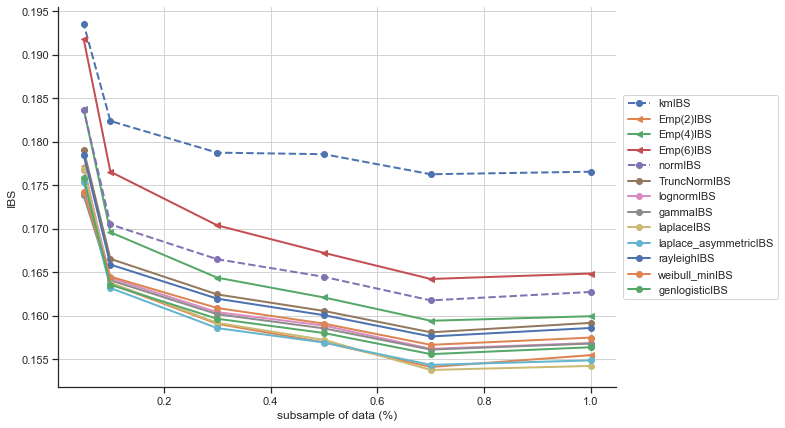

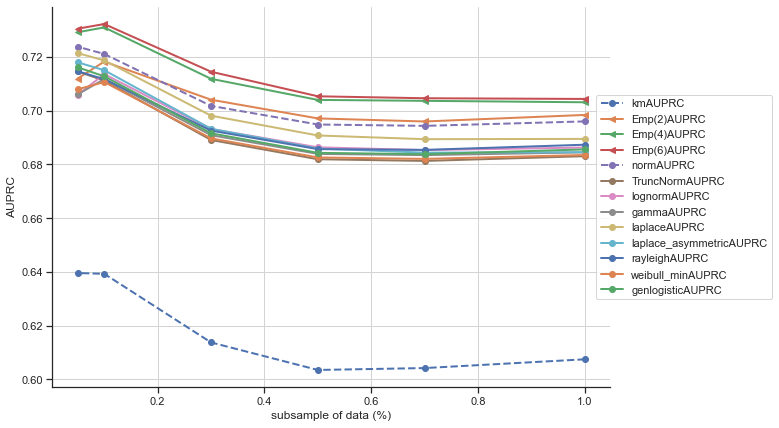

metabric


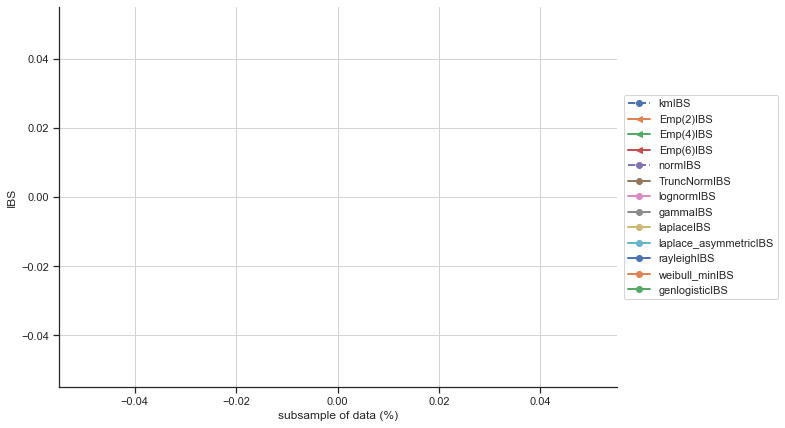

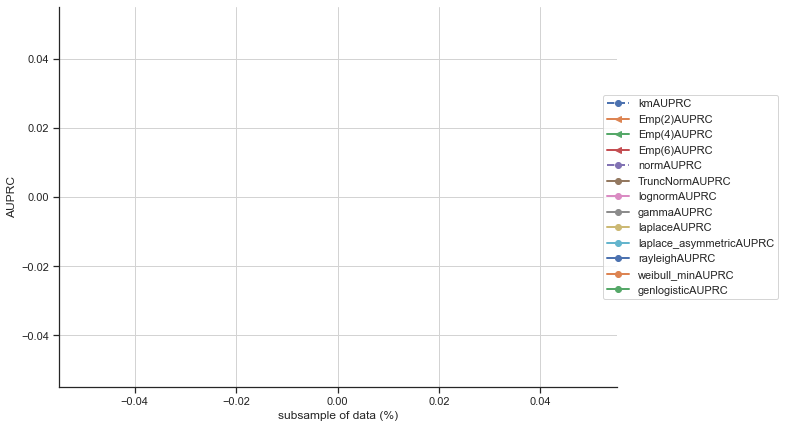

rott2


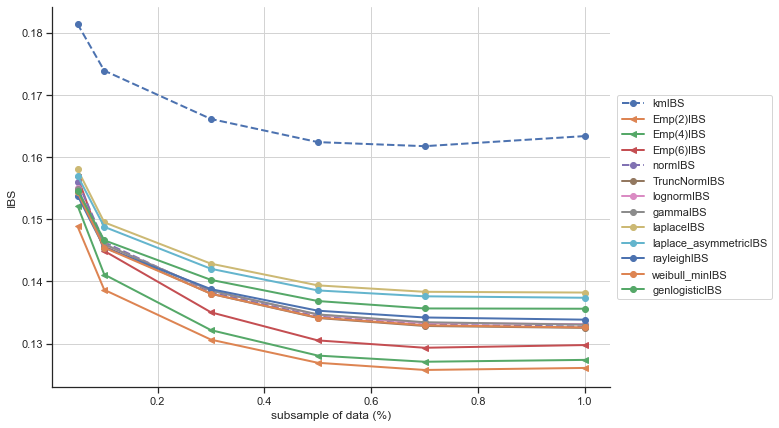

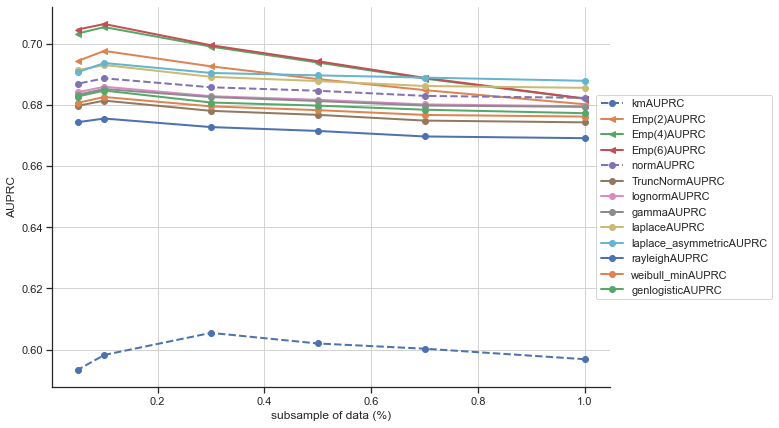

smarto


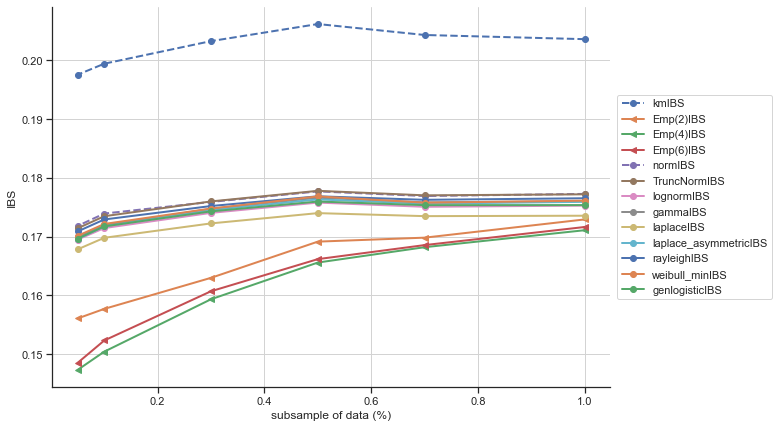

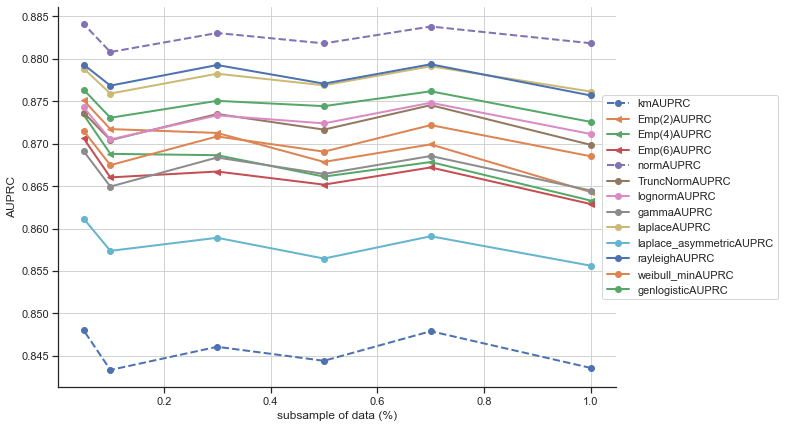

support2


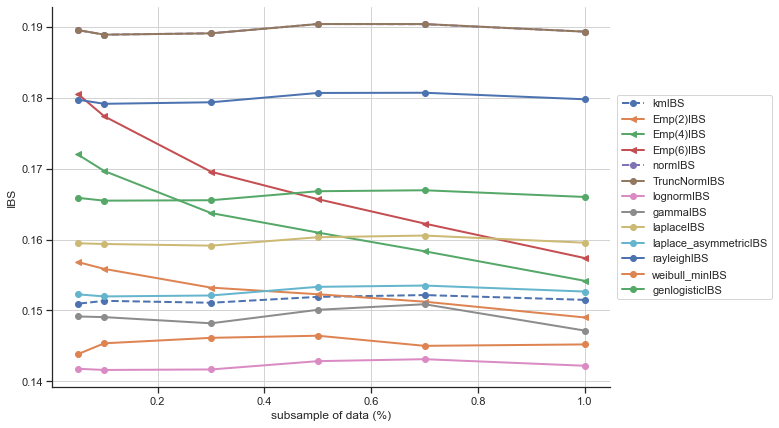

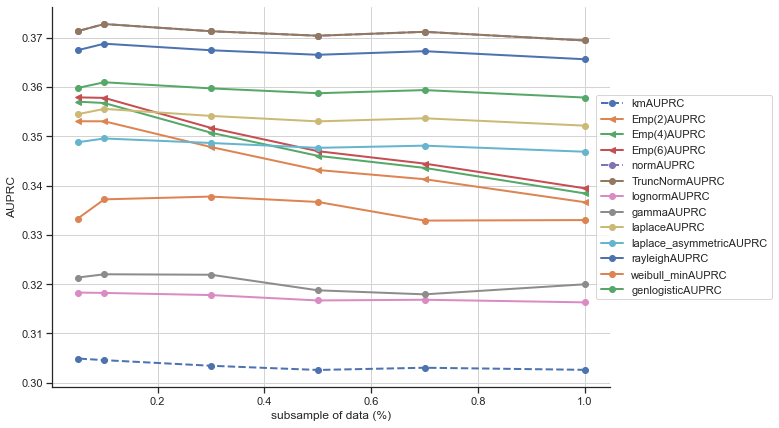

In [68]:
for ds_name in ["GBSG", "PBC", "metabric", "rott2", "smarto", "support2"]:
    print(ds_name)
    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[:-2:2]:
        df_ = df_res.T.copy()
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], 1 - df_[c] / df_["kmIBS"], label=c)
    plt.ylabel("IBS")
    plt.xlabel("subsample of data (%)")
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[1:-2:2]:
        df_ = df_res.T.copy()
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], df_[c] / df_["kmAUPRC"] - 1, label=c)
    #plt.legend()
    plt.ylabel("AUPRC")
    plt.xlabel("subsample of data (%)")
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

In [408]:
print(df_res.iloc[:-2:2].rank().mean(axis=1).sort_values())
print(df_res.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

for g in df_res.loc["dataset"].unique():
    print("="*10, g, "="*10)
    g_sample = (df_res.T[df_res.T["dataset"] == g]).T
    print(g_sample.iloc[:-2:2].rank().mean(axis=1).sort_values())
    print(g_sample.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

Emp(2)IBS                 4.111111
gammaIBS                  4.750000
weibull_minIBS            4.777778
laplace_asymmetricIBS     5.166667
lognormIBS                5.444444
genlogisticIBS            5.888889
laplaceIBS                6.833333
Emp(4)IBS                 7.222222
rayleighIBS               8.250000
TruncNormIBS              8.527778
Emp(6)IBS                 8.805556
normIBS                  10.500000
kmIBS                    10.722222
dtype: float64
normAUPRC                   3.444444
Emp(6)AUPRC                 3.972222
Emp(4)AUPRC                 4.138889
laplaceAUPRC                4.250000
Emp(2)AUPRC                 5.222222
rayleighAUPRC               6.333333
genlogisticAUPRC            6.611111
laplace_asymmetricAUPRC     7.916667
TruncNormAUPRC              8.055556
lognormAUPRC                8.388889
weibull_minAUPRC            9.833333
gammaAUPRC                  9.916667
kmAUPRC                    12.916667
dtype: float64
========== GBSG ==========
laplace

In [409]:
df_pivot

kmIBS                                                    \
dataset        GBSG       PBC     WUHAN     rott2    smarto  support2   
subsample                                                               
0.05       0.188439  0.193545  0.075589  0.181429  0.197552  0.150950   
0.1        0.186339  0.182402  0.090513  0.173927  0.199430  0.151360   
0.3        0.180000  0.178763  0.098684  0.166144  0.203274  0.151091   
0.5        0.179662  0.178586  0.102199  0.162428  0.206179  0.151919   
0.7        0.179654  0.176281  0.104486  0.161774  0.204314  0.152176   
1.0        0.181901  0.176575  0.103984  0.163397  0.203603  0.151498   

            kmAUPRC                                ... genlogisticIBS  \
dataset        GBSG       PBC     WUHAN     rott2  ...          WUHAN   
subsample                                          ...                  
0.05       0.597004  0.639569  0.702283  0.593373  ...       0.083394   
0.1        0.591862  0.639284  0.669182  0.598277  ...       0.087638   
0.3        0.602622  0.613738  0.657160  0.605486  ...       0.091480   
0.5        0.597536  0.603496  0.661230  0.602023  ...       0.095083   
0.7        0.592469  0.604201  0.659637  0.600324  ...       0.096882   
1.0        0.591499  0.607461  0.645390  0.596880  ...       0.097157   

                                        genlogisticAUPRC                      \
dataset       rott2    smarto  support2             GBSG       PBC     WUHAN   
subsample                                                                      
0.05       0.154622  0.169666  0.165890         0.682259  0.716156  0.735870   
0.1        0.146627  0.171753  0.165486         0.671579  0.712789  0.710051   
0.3        0.140255  0.174309  0.165547         0.675565  0.691597  0.694545   
0.5        0.136855  0.175981  0.166816         0.672299  0.684309  0.694130   
0.7        0.135662  0.175367  0.166953         0.668224  0.683823  0.692067   
1.0        0.135617  0.175375  0.166008         0.669866  0.685590  0.679683   

                                         
dataset       rott2    smarto  support2  
subsample                                
0.05       0.682705  0.876346  0.359786  
0.1        0.684667  0.873045  0.360943  
0.3        0.680750  0.875038  0.359702  
0.5        0.679738  0.874412  0.358725  
0.7        0.678399  0.876159  0.359358  
1.0        0.677257  0.872552  0.357847  

[6 rows x 156 columns]

In [410]:
# Mean (by dataset) ranked methods by meaning quality by subsample
df_pivot = pd.pivot(df_res.T, columns=["dataset"], index="subsample").astype(float)

df_ibs_pivot = df_pivot.T.mean(axis=1).unstack()[::2]
df_auprc_pivot = df_pivot.T.mean(axis=1).unstack()[1::2]

df_ibs_rank = df_ibs_pivot.rank().mean(axis=1)
df_ibs_rank.index = df_ibs_rank.index.str[:-3]

df_auprc_rank = df_auprc_pivot.rank(ascending=False).mean(axis=1)
df_auprc_rank.index = df_auprc_rank.index.str[:-5]

print(pd.concat([df_ibs_rank, df_auprc_rank], axis=1).mean(axis=1).sort_values())

Emp(2)                 4.666667
Emp(4)                 5.500000
laplace                5.583333
Emp(6)                 6.166667
genlogistic            6.166667
laplace_asymmetric     6.666667
norm                   7.083333
gamma                  7.250000
lognorm                7.333333
weibull_min            7.333333
rayleigh               7.416667
TruncNorm              8.166667
km                    11.666667
dtype: float64


In [411]:
# Mean quality by dataset and subsample
print(df_res.iloc[:-2:2].mean(axis=1).sort_values()) # .rank(ascending=False)
print(df_res.iloc[1:-2:2].mean(axis=1).sort_values())

Emp(2)IBS                 0.14528
weibull_minIBS            0.14554
gammaIBS                 0.146072
laplace_asymmetricIBS    0.147194
lognormIBS               0.147222
laplaceIBS                0.14952
genlogisticIBS           0.149527
Emp(4)IBS                0.150624
rayleighIBS              0.152829
TruncNormIBS             0.154346
Emp(6)IBS                0.155707
normIBS                  0.156946
kmIBS                    0.163612
dtype: object
kmAUPRC                    0.604627
lognormAUPRC               0.651239
gammaAUPRC                 0.653457
weibull_minAUPRC           0.656613
laplace_asymmetricAUPRC    0.659704
TruncNormAUPRC             0.663788
genlogisticAUPRC           0.664106
rayleighAUPRC              0.664922
Emp(2)AUPRC                0.667009
laplaceAUPRC               0.668007
Emp(4)AUPRC                0.671686
Emp(6)AUPRC                0.671766
normAUPRC                  0.671965
dtype: object


In [412]:
df_ibs_rank = df_res.iloc[:-2:2].rank().mean(axis=1)
df_ibs_rank.index = df_ibs_rank.index.str[:-3]

df_auprc_rank = df_res.iloc[1:-2:2].rank(ascending=False).mean(axis=1)
df_auprc_rank.index = df_auprc_rank.index.str[:-5]

print("="*10, "IBS", "="*10)
print(df_ibs_rank.sort_values())
print("="*10, "AUPRC", "="*10)
print(df_auprc_rank.sort_values())
print("="*10, "Mean", "="*10)
print(pd.concat([df_ibs_rank, df_auprc_rank], axis=1).mean(axis=1).sort_values())

========== IBS ==========
Emp(2)                 4.111111
gamma                  4.750000
weibull_min            4.777778
laplace_asymmetric     5.166667
lognorm                5.444444
genlogistic            5.888889
laplace                6.833333
Emp(4)                 7.222222
rayleigh               8.250000
TruncNorm              8.527778
Emp(6)                 8.805556
norm                  10.500000
km                    10.722222
dtype: float64
========== AUPRC ==========
norm                   3.444444
Emp(6)                 3.972222
Emp(4)                 4.138889
laplace                4.250000
Emp(2)                 5.222222
rayleigh               6.333333
genlogistic            6.611111
laplace_asymmetric     7.916667
TruncNorm              8.055556
lognorm                8.388889
weibull_min            9.833333
gamma                  9.916667
km                    12.916667
dtype: float64
========== Mean ==========
Emp(2)                 4.666667
laplace                5.

In [418]:
from IPython.display import display

# IBS growth
df_IBS_growth = 1 - df_res.iloc[:-2:2] / df_res.iloc[[0]].values
display(df_IBS_growth)

df_IBS_growth_rank = df_IBS_growth.mean(axis=1).rank(ascending=False)
df_IBS_growth_rank.index = df_IBS_growth_rank.index.str[:-3]
print(df_IBS_growth_rank.sort_values())

# AUPRC growth
df_AUPRC_growth = df_res.iloc[1:-2:2] / df_res.iloc[[1]].values - 1
display(df_AUPRC_growth)

df_AUPRC_growth_rank = df_AUPRC_growth.mean(axis=1).rank(ascending=False)
df_AUPRC_growth_rank.index = df_AUPRC_growth_rank.index.str[:-5]
print(df_AUPRC_growth_rank.sort_values())
print(pd.concat([df_IBS_growth_rank, df_AUPRC_growth_rank], axis=1).mean(axis=1).sort_values())

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
kmIBS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)IBS,0.140425,0.124262,0.12104,0.110362,0.098615,0.071681,0.119376,0.125668,0.121065,0.110043,...,0.179548,0.198116,0.209169,0.209894,0.016377,0.006141,-0.002441,-0.01412,-0.029752,-0.039015
Emp(4)IBS,0.116846,0.097135,0.091148,0.078554,0.062381,0.031763,0.094054,0.095509,0.092193,0.080354,...,0.196809,0.21604,0.245646,0.254236,-0.017727,-0.040561,-0.059709,-0.083705,-0.120963,-0.139563
Emp(6)IBS,0.09129,0.069316,0.062107,0.045656,0.024196,-0.008594,0.066281,0.068269,0.063496,0.046712,...,0.19399,0.209339,0.236115,0.248163,-0.038899,-0.06624,-0.09071,-0.122257,-0.171928,-0.19623
normIBS,0.103162,0.088327,0.085735,0.076556,0.067817,0.046344,0.078249,0.082237,0.078923,0.068505,...,0.138102,0.1346,0.127836,0.130226,-0.249682,-0.25095,-0.253248,-0.251461,-0.24798,-0.255587
TruncNormIBS,0.120816,0.107822,0.105033,0.096804,0.090554,0.068365,0.098375,0.103037,0.10087,0.091129,...,0.137632,0.134172,0.130118,0.132299,-0.249623,-0.251133,-0.253259,-0.251444,-0.247978,-0.255768
lognormIBS,0.130995,0.117751,0.115681,0.10581,0.099742,0.081174,0.111509,0.113807,0.110297,0.102537,...,0.147343,0.143745,0.140215,0.142009,0.061327,0.059425,0.059665,0.062267,0.064391,0.060721
gammaIBS,0.134763,0.121846,0.118723,0.10843,0.101966,0.08334,0.11184,0.114307,0.112089,0.103847,...,0.143318,0.140388,0.137771,0.140063,0.028606,0.00851,0.012002,0.019177,0.01516,0.01188
laplaceIBS,0.124547,0.113408,0.119042,0.105779,0.095568,0.06951,0.126412,0.127582,0.11949,0.109429,...,0.15603,0.152568,0.148514,0.150397,-0.053197,-0.055138,-0.055369,-0.053302,-0.052959,-0.056499
laplace_asymmetricIBS,0.152962,0.139799,0.137566,0.125559,0.11325,0.079479,0.122791,0.124276,0.121202,0.112778,...,0.144718,0.141375,0.138755,0.14149,-0.007745,-0.00881,-0.009321,-0.006777,-0.004115,-0.008796


weibull_min            1.0
gamma                  2.0
Emp(2)                 3.0
laplace_asymmetric     4.0
lognorm                5.0
genlogistic            6.0
laplace                7.0
rayleigh               8.0
Emp(4)                 9.0
TruncNorm             10.0
norm                  11.0
Emp(6)                12.0
km                    13.0
dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
kmAUPRC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Emp(2)AUPRC,0.156616,0.153056,0.151787,0.14654,0.154358,0.148995,0.149737,0.151906,0.155142,0.147202,...,0.02773,0.029761,0.033629,0.031917,0.112351,0.126179,0.134027,0.146192,0.159049,0.157821
Emp(4)AUPRC,0.161679,0.162387,0.161776,0.159933,0.172579,0.172896,0.157497,0.164625,0.166558,0.159891,...,0.025682,0.026665,0.03017,0.029911,0.118223,0.13376,0.143514,0.155761,0.171229,0.170853
Emp(6)AUPRC,0.16038,0.162683,0.163272,0.160828,0.174928,0.174929,0.15954,0.16622,0.168789,0.164177,...,0.024562,0.024391,0.026886,0.02665,0.12167,0.136624,0.146633,0.158976,0.174653,0.1737
normAUPRC,0.149381,0.145129,0.141702,0.138205,0.151595,0.153323,0.145772,0.149205,0.151387,0.143463,...,0.044257,0.043669,0.044387,0.042533,0.220733,0.224795,0.224028,0.223584,0.223822,0.217699
TruncNormAUPRC,0.128635,0.123295,0.121102,0.117876,0.132417,0.138027,0.124456,0.127603,0.129967,0.122794,...,0.032232,0.032396,0.032087,0.030238,0.220748,0.224832,0.224019,0.223597,0.223817,0.217733
lognormAUPRC,0.136115,0.131263,0.128542,0.124945,0.138833,0.142544,0.12977,0.134278,0.137313,0.129462,...,0.033104,0.032206,0.032185,0.030954,0.045217,0.045509,0.04659,0.047256,0.044771,0.043863
gammaAUPRC,0.131299,0.125646,0.12403,0.120924,0.135103,0.13714,0.126807,0.131188,0.133256,0.125697,...,0.026051,0.026344,0.025601,0.024871,0.057333,0.049124,0.053382,0.060836,0.057194,0.053831
laplaceAUPRC,0.147015,0.14152,0.135579,0.133037,0.147654,0.153505,0.13505,0.141002,0.144623,0.137523,...,0.038411,0.038002,0.038588,0.036354,0.163653,0.166953,0.166618,0.166981,0.167323,0.16246
laplace_asymmetricAUPRC,0.118568,0.111503,0.11143,0.109066,0.131478,0.146228,0.126916,0.132715,0.136545,0.129585,...,0.014255,0.015171,0.016626,0.015508,0.146171,0.14864,0.148876,0.148898,0.14761,0.143826


norm                   1.0
Emp(6)                 2.0
Emp(4)                 3.0
laplace                4.0
rayleigh               5.0
TruncNorm              6.0
Emp(2)                 7.0
genlogistic            8.0
laplace_asymmetric     9.0
weibull_min           10.0
gamma                 11.0
lognorm               12.0
km                    13.0
dtype: float64
Emp(2)                 5.0
laplace                5.5
weibull_min            5.5
Emp(4)                 6.0
norm                   6.0
gamma                  6.5
laplace_asymmetric     6.5
rayleigh               6.5
Emp(6)                 7.0
genlogistic            7.0
TruncNorm              8.0
lognorm                8.5
km                    13.0
dtype: float64


### Metabric EDA

1. https://github.com/baskayj/Censoring-sensitivity-analysis-for-survival-models/tree/main
2. https://github.com/baskayj/Censoring-sensitivity-analysis-for-survival-models/blob/main/Data/metabric.tsv

In [516]:
def load_metabric_dataset(name):
    dir_env = join(dirname(__file__), "data")
    df = pd.read_csv(join(dir_env, f'metabric.tsv'))
    df = df.rename({"time": TIME_NAME, "event": CENS_NAME}, axis=1)

    sign_c = [c for c in df.columns if c.startswith("num_") or c.startswith("fac_")]
    categ_c = [c for c in df.columns if c.startswith("fac_")]

    y = get_y(cens=df[CENS_NAME], time=df[TIME_NAME].astype("int"))
    X = df.loc[:, sign_c]

    for c in categ_c:
        le = preprocessing.LabelEncoder()
        X[c] = le.fit_transform(X[c])

    if y[TIME_NAME].min() == 0:
        y[TIME_NAME] += 1
    return X, y, sign_c, categ_c, []

df = pd.read_csv(r"C:\Users\vasiliev\Desktop\PycharmProjects\dev-survivors\survivors\datasets\data\metabric.tsv", 
                 sep="\t",header=4)

obsolete_feat = ["PATIENT_ID", "VITAL_STATUS", "RFS_MONTHS", "RFS_STATUS", 
                 "BREAST_SURGERY", "SEX", "LATERALITY"]
target_feat = ["OS_STATUS", "OS_MONTHS"]
cont_feat = ["LYMPH_NODES_EXAMINED_POSITIVE", "NPI", "CELLULARITY", "AGE_AT_DIAGNOSIS"]
df = df[df[target_feat].notna().all(axis=1)].reset_index(drop=True)

df["CELLULARITY"] = df["CELLULARITY"].map({"Low": 0, "Moderate": 1, "High": 2})
df["CHEMOTHERAPY"] = df["CHEMOTHERAPY"].map({"YES": True, "NO": False})
df["ER_IHC"] = df["ER_IHC"].map({"Positve": True, "Negative": False})
df["HORMONE_THERAPY"] = df["HORMONE_THERAPY"].map({"YES": True, "NO": False})
df["RADIO_THERAPY"] = df["RADIO_THERAPY"].map({"YES": True, "NO": False})
df["BREAST_SURGERY_MASTECTOMY"] = df["BREAST_SURGERY"].map({"MASTECTOMY": True, "BREAST CONSERVING": False})
df["LATERALITY_LEFT"] = df["LATERALITY"].map({"Left": True, "Right": False})
df["RFS_RECURRED"] = df["RFS_STATUS"].map({"1:Recurred": True, "0:Not Recurred": False})
df["INFERRED_MENOPAUSAL_POST"] = df["INFERRED_MENOPAUSAL_STATE"].map({"Post": True, "Pre": False})

sign_c = sorted(list(set(df.columns) - set(obsolete_feat) - set(target_feat)))
categ_c = sorted(list(set(sign_c) - set(cont_feat)))

y = cnt.get_y(cens=df["OS_STATUS"] == "1:DECEASED", time=df["OS_MONTHS"].astype("int"))
X = df.loc[:, sign_c]

if y[cnt.TIME_NAME].min() == 0:
    y[cnt.TIME_NAME] += 1

In [518]:
X.isna().sum(axis=0)

AGE_AT_DIAGNOSIS                   0
BREAST_SURGERY_MASTECTOMY         26
CELLULARITY                       64
CHEMOTHERAPY                       1
CLAUDIN_SUBTYPE                    1
COHORT                             0
ER_IHC                            43
HER2_SNP6                          1
HISTOLOGICAL_SUBTYPE              44
HORMONE_THERAPY                    1
INFERRED_MENOPAUSAL_POST           1
INFERRED_MENOPAUSAL_STATE          1
INTCLUST                           1
LATERALITY_LEFT                  111
LYMPH_NODES_EXAMINED_POSITIVE     76
NPI                                1
RADIO_THERAPY                      1
RFS_RECURRED                       1
THREEGENE                        217
dtype: int64

In [508]:
df = pd.read_csv(r"C:\Users\vasiliev\Desktop\PycharmProjects\dev-survivors\survivors\datasets\data\metabric.tsv", 
                 sep="\t",header=4)
df = df[df[target_feat].notna().all(axis=1)].reset_index(drop=True)
df.shape

(1981, 24)

In [515]:
df["INFERRED_MENOPAUSAL_STATE"].value_counts()

INFERRED_MENOPAUSAL_STATE
Post    1556
Pre      424
Name: count, dtype: int64

<Axes: ylabel='Density'>

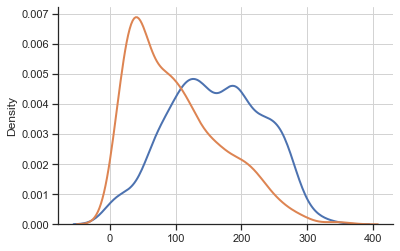

In [501]:
sns.kdeplot(y[y["cens"] == False]["time"])
sns.kdeplot(y[y["cens"] == True]["time"])

In [469]:
df[["RFS_STATUS", "OS_STATUS"]].value_counts()

RFS_STATUS      OS_STATUS 
0:Not Recurred  0:LIVING      745
1:Recurred      1:DECEASED    711
0:Not Recurred  1:DECEASED    432
1:Recurred      0:LIVING       92
Name: count, dtype: int64

In [488]:
df["CLAUDIN_SUBTYPE"].value_counts()

CLAUDIN_SUBTYPE
LumA           700
LumB           475
Her2           224
claudin-low    218
Basal          209
Normal         148
NC               6
Name: count, dtype: int64